In [50]:
from ultralytics import YOLO
import os
import torch
import sys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import pandas as pd
import numpy as np

In [3]:
# Kiểm tra CUDA có sẵn không
print(f"CUDA available: {torch.cuda.is_available()}")

# Số lượng GPU
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Tên GP .cuda.is_available():
print(f"GPU name: {torch.cuda.get_device_name(0)}")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version in PyTorch: {torch.version.cuda}")

CUDA available: True
Number of GPUs: 1
GPU name: NVIDIA GeForce GTX 1650 with Max-Q Design
PyTorch version: 2.6.0+cu124
CUDA version in PyTorch: 12.4


In [14]:
os.chdir(r'E:\Workspace\Code\Python\CV_project') # root project directory

In [57]:
TRAIN_IMG_DIR = r"data\train\images"
TRAIN_LABEL_DIR = r"data\train\labels"
VALID_IMG_DIR = r"data\val\images"
VALID_LABEL_DIR = r"data\val\labels"
TEST_IMG_DIR = r"data\test\images"
TEST_LABEL_DIR = r"data\test\labels"

In [58]:
# Kiểm tra số lượng ảnh trong mỗi tập
def count_images(img_dir):
    return len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

train_count = count_images(TRAIN_IMG_DIR)
valid_count = count_images(VALID_IMG_DIR)
test_count = count_images(TEST_IMG_DIR)
total_count = train_count + valid_count + test_count

print(f"\n=== THỐNG KÊ SỐ LƯỢNG ẢNH ===")
print(f"Train: {train_count} ảnh ({train_count/total_count:.1%})")
print(f"Valid: {valid_count} ảnh ({valid_count/total_count:.1%})")
print(f"Test: {test_count} ảnh ({test_count/total_count:.1%})")
print(f"Tổng: {total_count} ảnh")


=== THỐNG KÊ SỐ LƯỢNG ẢNH ===
Train: 1386 ảnh (70.0%)
Valid: 396 ảnh (20.0%)
Test: 199 ảnh (10.0%)
Tổng: 1981 ảnh


In [59]:
# Hàm visualize mẫu dữ liệu với bounding boxes
def visualize_traffic_signs(img_dir, label_dir, class_names, num_samples=6, title="Mẫu dữ liệu biển báo giao thông"):
    """
    Hiển thị các mẫu ảnh biển báo giao thông với bounding boxes
    """
    # Lấy danh sách ảnh
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print(f"Không tìm thấy ảnh trong {img_dir}")
        return
        
    # Chọn ngẫu nhiên num_samples ảnh
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Tính số hàng và cột cho subplot
    cols = 3
    rows = (len(samples) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, sample in enumerate(samples):
        img_file = os.path.join(img_dir, sample)
        label_file = os.path.join(label_dir, os.path.splitext(sample)[0] + '.txt')
        
        # Đọc ảnh
        image = Image.open(img_file)
        img_width, img_height = image.size
        
        # Hiển thị ảnh
        axes[i].imshow(image)
        axes[i].set_title(f"Ảnh {i+1}: {sample[:20]}...", fontsize=10)
        axes[i].axis('off')
        
        # Đọc nhãn nếu tồn tại
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
                color_idx = 0
                
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Chuyển từ tọa độ chuẩn hóa sang pixel
                        x_min = int((x_center - width/2) * img_width)
                        y_min = int((y_center - height/2) * img_height)
                        box_width = int(width * img_width)
                        box_height = int(height * img_height)
                        
                        # Vẽ bounding box
                        color = colors[color_idx % len(colors)]
                        rect = patches.Rectangle(
                            (x_min, y_min), box_width, box_height, 
                            linewidth=2, edgecolor=color, facecolor='none'
                        )
                        axes[i].add_patch(rect)
                        
                        # Hiển thị class name
                        class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                        axes[i].text(x_min, y_min-5, f"{class_name}", 
                                   color='white', backgroundcolor=color, fontsize=8, weight='bold')
                        color_idx += 1
    
    # Ẩn các subplot không sử dụng
    for i in range(len(samples), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()


=== HIỂN THỊ MẪU DỮ LIỆU TẬP TRAIN ===


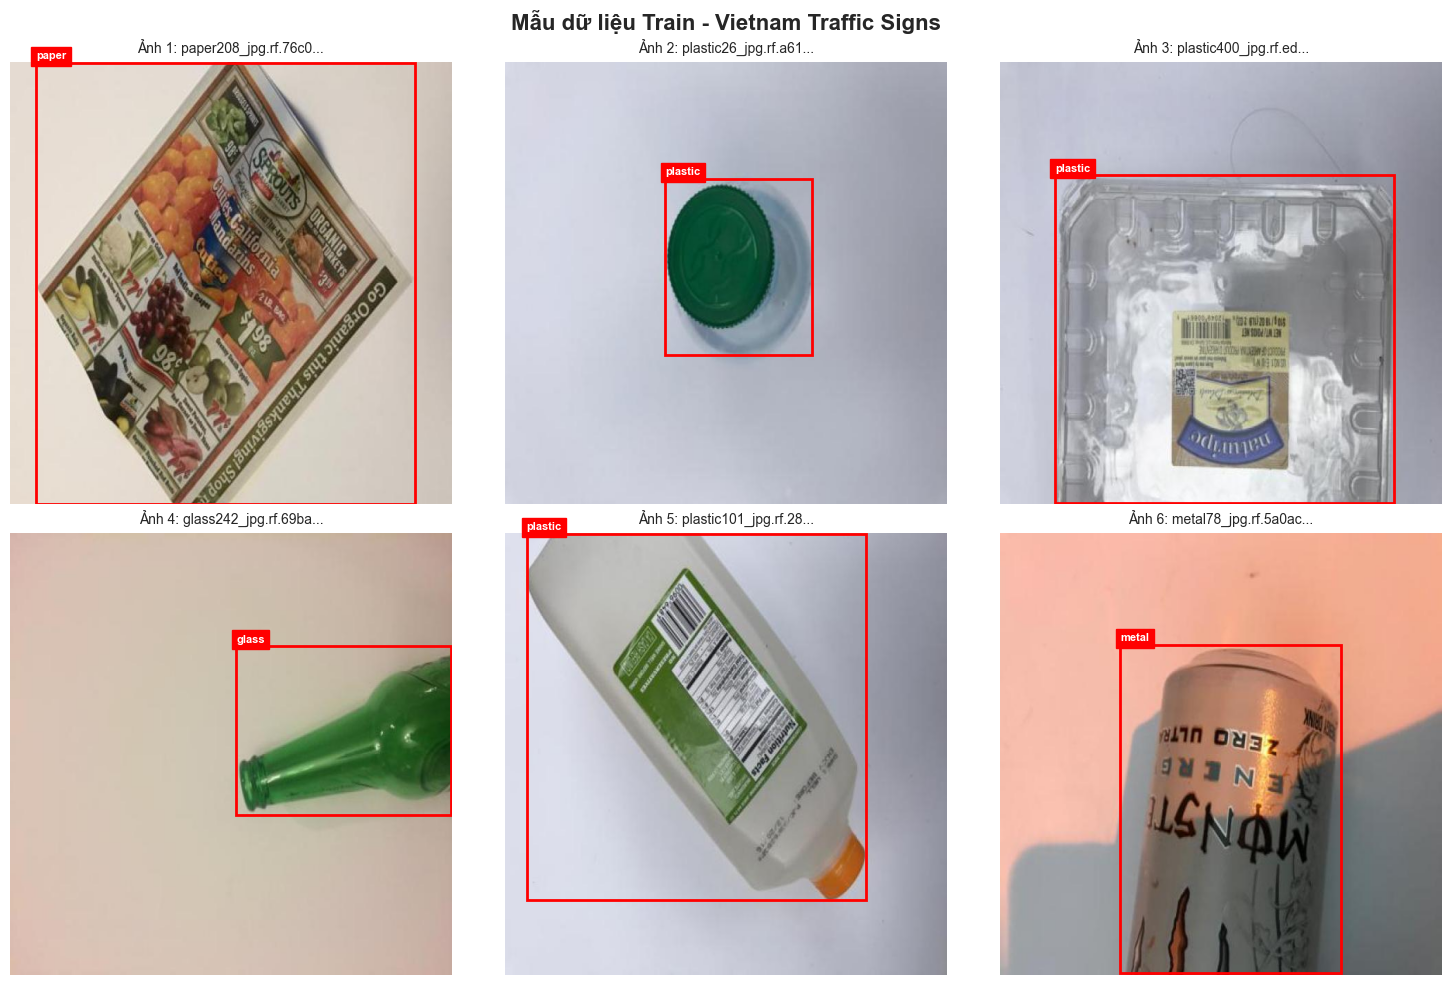

In [60]:
# Hiển thị mẫu từ tập train
print("=== HIỂN THỊ MẪU DỮ LIỆU TẬP TRAIN ===")
visualize_traffic_signs(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, ['glass', 'metal', 'paper', 'plastic'], 
                        num_samples=6, title="Mẫu dữ liệu Train - Vietnam Traffic Signs")

=== HIỂN THỊ MẪU DỮ LIỆU TẬP VALIDATION ===


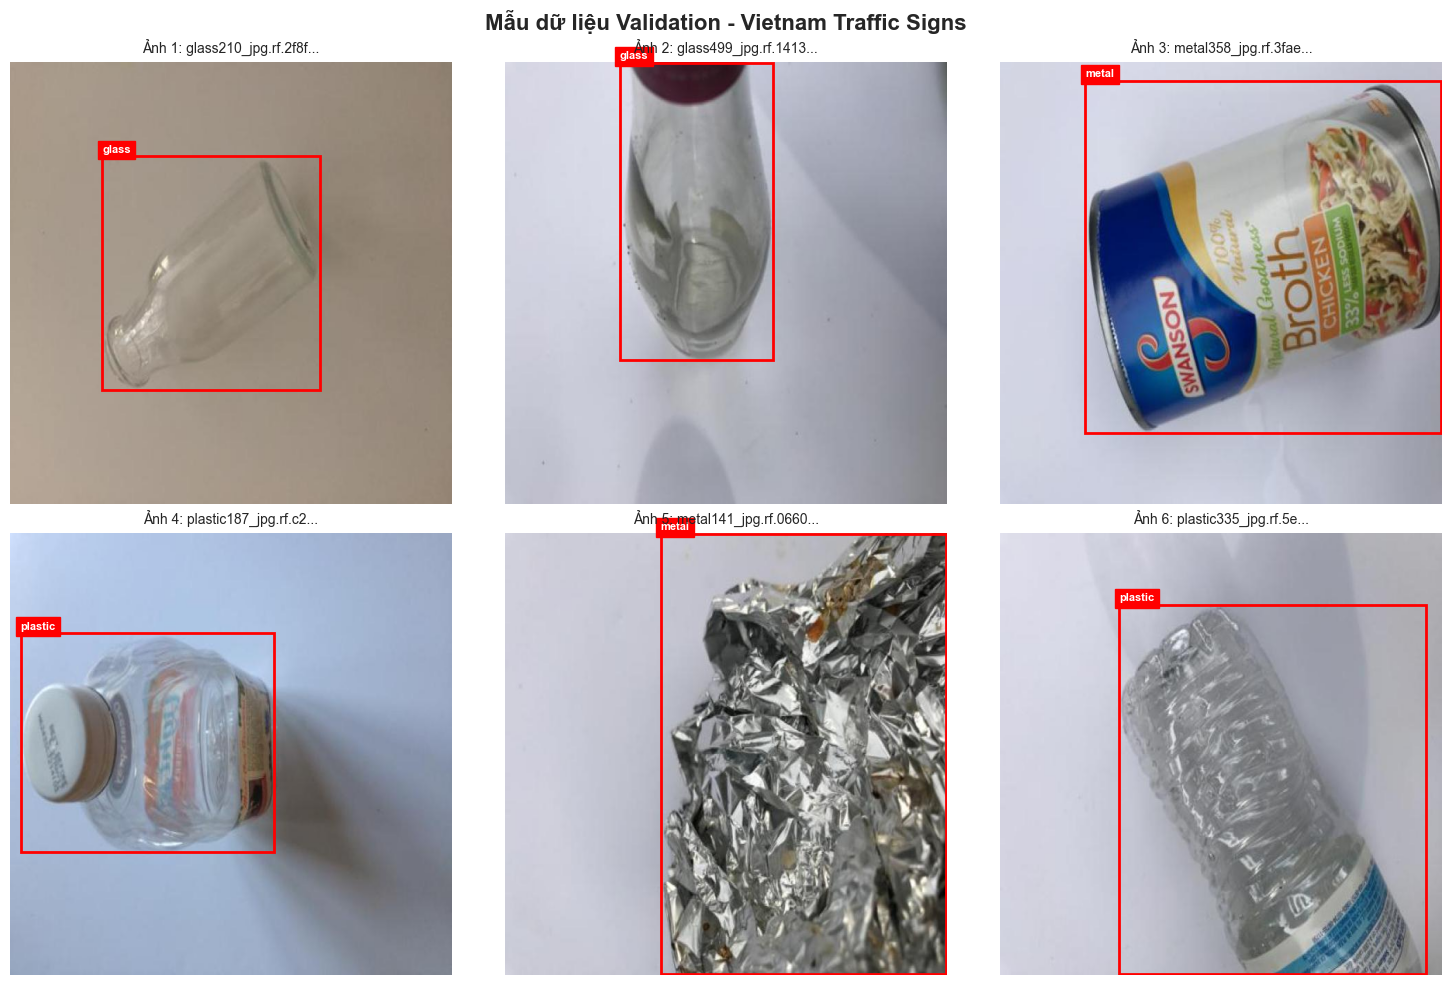

In [61]:
# Hiển thị mẫu từ tập validation
print("=== HIỂN THỊ MẪU DỮ LIỆU TẬP VALIDATION ===")
visualize_traffic_signs(VALID_IMG_DIR, VALID_LABEL_DIR, ['glass', 'metal', 'paper', 'plastic'], 
                        num_samples=6, title="Mẫu dữ liệu Validation - Vietnam Traffic Signs")

=== HIỂN THỊ MẪU DỮ LIỆU TẬP VALIDATION ===


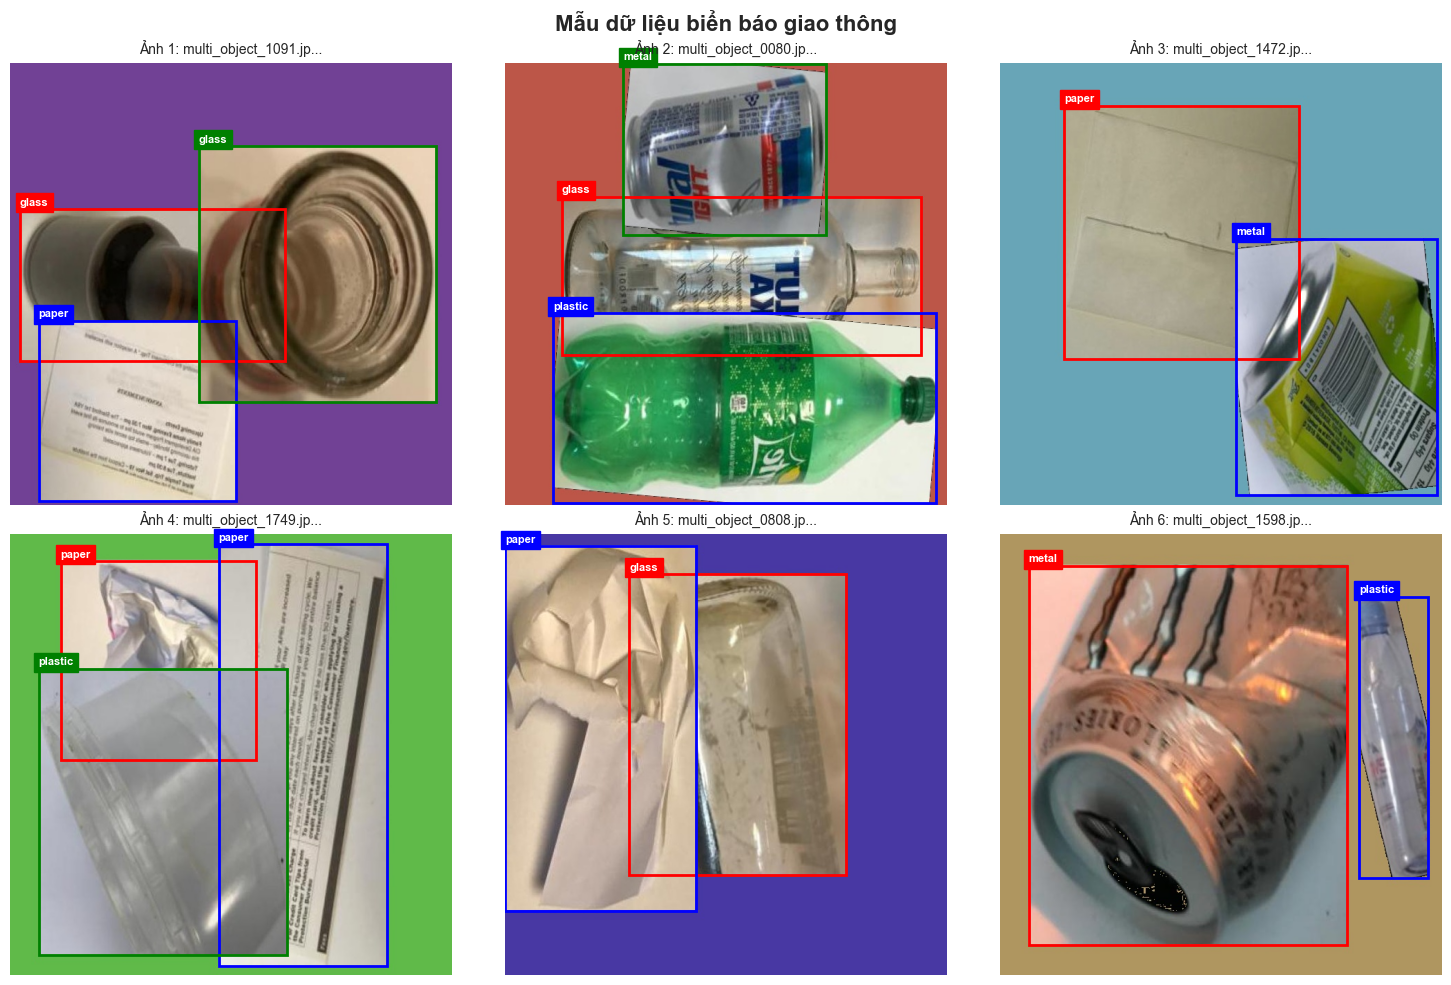

In [74]:
# Hiển thị mẫu từ tập validation
print("=== HIỂN THỊ MẪU DỮ LIỆU TẬP VALIDATION ===")
visualize_traffic_signs(r"data_split\train\images", r"data_split\train\labels", ['glass', 'metal', 'paper', 'plastic'], 
                        num_samples=6)

=== PHÂN TÍCH PHÂN BỐ CLASSES TRONG DATASET ===
train: Tổng 1393 objects trong 1386 ảnh
vaid: Tổng 397 objects trong 396 ảnh
test: Tổng 200 objects trong 199 ảnh

===  SAMPLES OF CLASSES ===
Class_Name  Train  Valid  Test  Total
     paper    420    115    59    594
     glass    335    112    51    498
   plastic    342     95    51    488
     metal    296     75    39    410


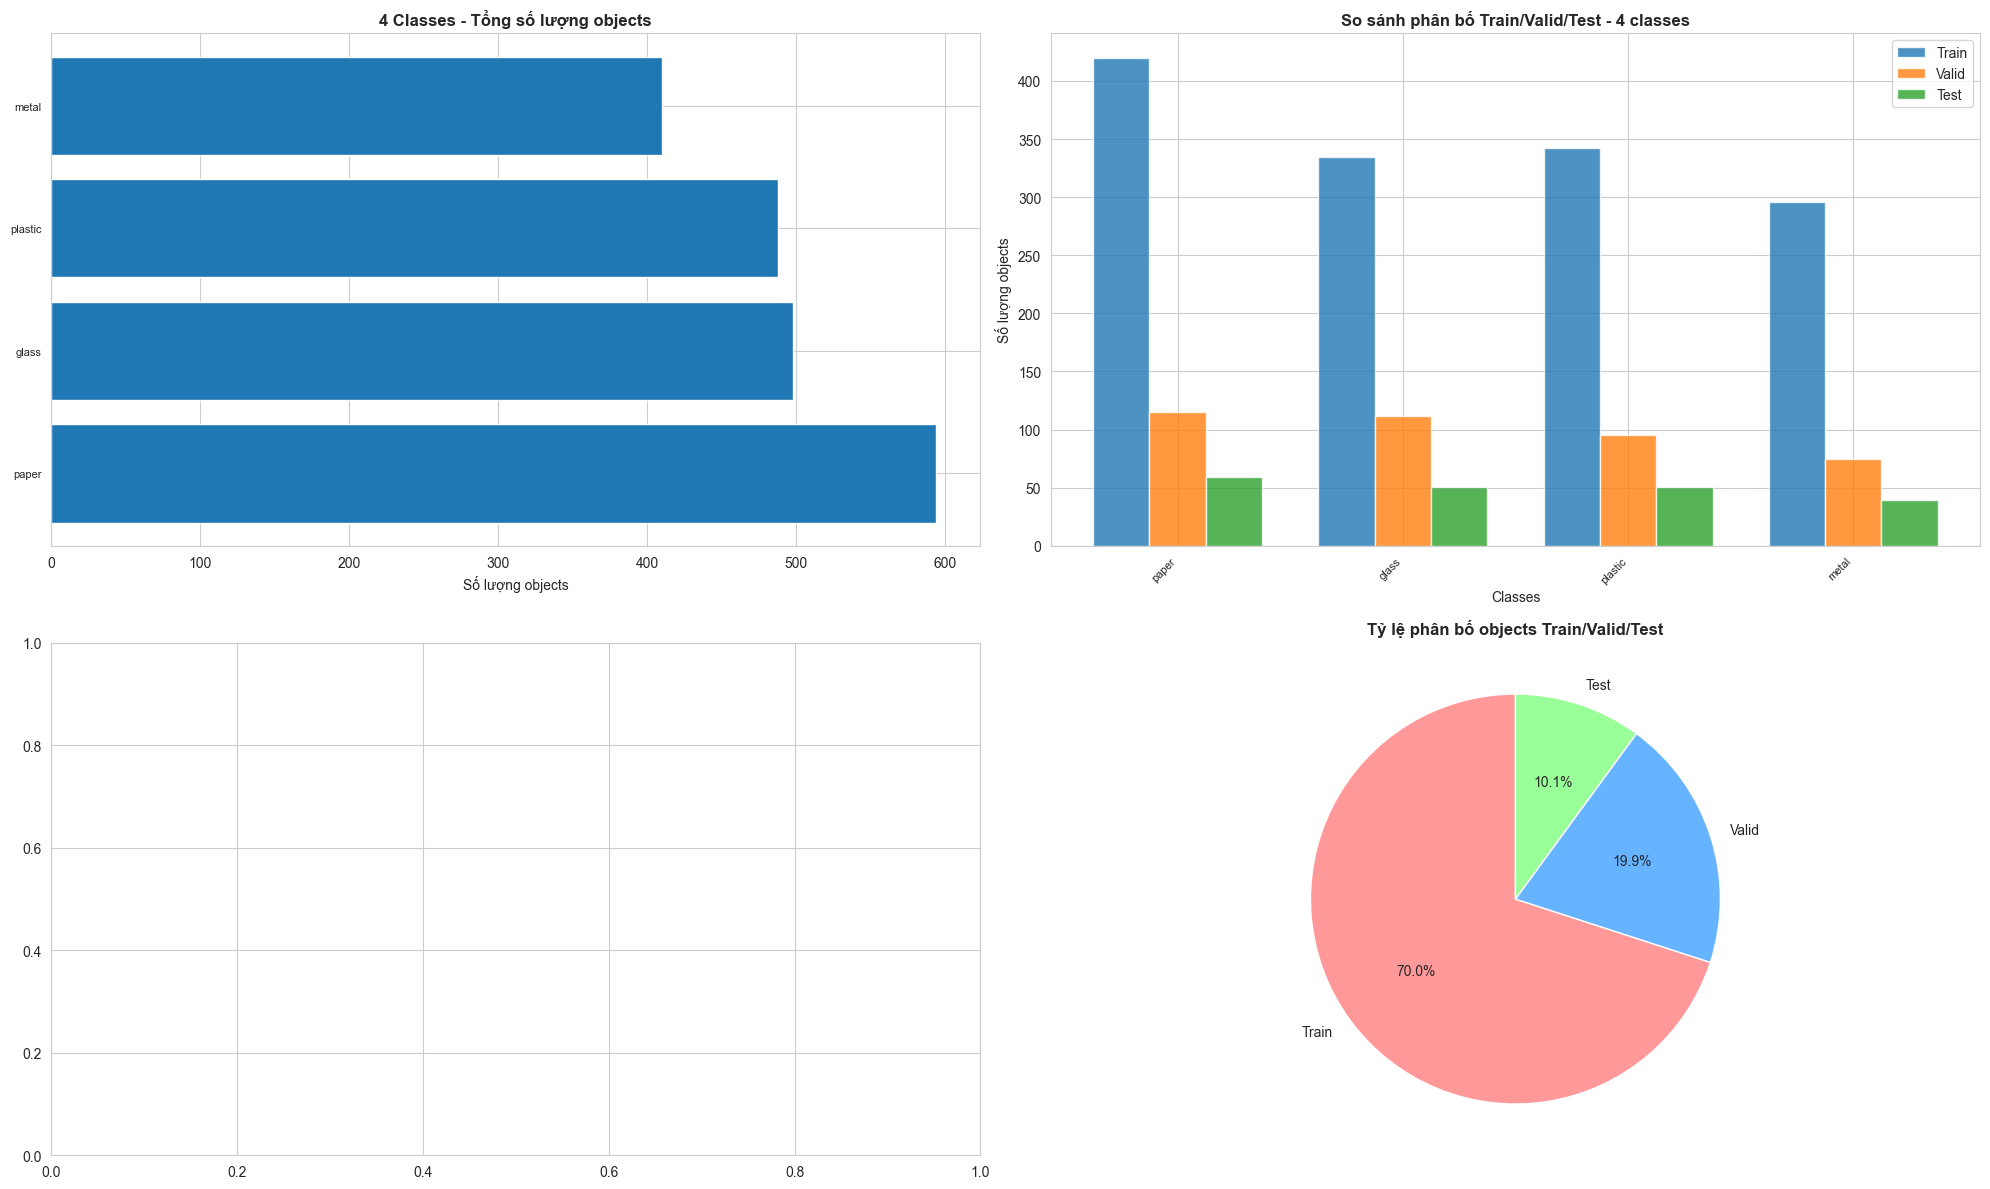

In [62]:
# Phân tích phân bố classes trong dataset
def analyze_class_distribution(label_dirs, class_names, set_names):
    """
    Phân tích phân bố các classes trong từng tập dữ liệu
    """
    all_class_counts = []
    
    for label_dir, set_name in zip(label_dirs, set_names):
        class_counts = [0] * len(class_names)
        
        if os.path.exists(label_dir):
            label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
            
            for label_file in label_files:
                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            if 0 <= class_id < len(class_names):
                                class_counts[class_id] += 1
        
        all_class_counts.append(class_counts)
        print(f"{set_name}: Tổng {sum(class_counts)} objects trong {len(label_files) if os.path.exists(label_dir) else 0} ảnh")
    
    # Tạo DataFrame để hiển thị
    df = pd.DataFrame({
        'Class_ID': range(len(class_names)),
        'Class_Name': class_names,
        'Train': all_class_counts[0],
        'Valid': all_class_counts[1],
        'Test': all_class_counts[2]
    })
    
    df['Total'] = df['Train'] + df['Valid'] + df['Test']
    
    # Sắp xếp theo tổng số lượng giảm dần
    df = df.sort_values('Total', ascending=False)
    
    # Hiển thị top 10 classes có nhiều samples nhất
    print(f"\n===  SAMPLES OF CLASSES ===")
    print(df.head(10)[['Class_Name', 'Train', 'Valid', 'Test', 'Total']].to_string(index=False))
    
    # Vẽ biểu đồ phân bố
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Biểu đồ tổng quan top 20
    top_20 = df.head(20)
    axes[0,0].barh(range(len(top_20)), top_20['Total'])
    axes[0,0].set_yticks(range(len(top_20)))
    axes[0,0].set_yticklabels(top_20['Class_Name'], fontsize=8)
    axes[0,0].set_title('4 Classes - Tổng số lượng objects', fontsize=12, weight='bold')
    axes[0,0].set_xlabel('Số lượng objects')
    
    # So sánh Train/Valid/Test cho top 15
    top_15 = df.head(15)
    x = np.arange(len(top_15))
    width = 0.25
    
    axes[0,1].bar(x - width, top_15['Train'], width, label='Train', alpha=0.8)
    axes[0,1].bar(x, top_15['Valid'], width, label='Valid', alpha=0.8)
    axes[0,1].bar(x + width, top_15['Test'], width, label='Test', alpha=0.8)
    
    axes[0,1].set_xlabel('Classes')
    axes[0,1].set_ylabel('Số lượng objects')
    axes[0,1].set_title('So sánh phân bố Train/Valid/Test - 4 classes', fontsize=12, weight='bold')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(top_15['Class_Name'], rotation=45, ha='right', fontsize=8)
    axes[0,1].legend()
    
    # Pie chart cho tỷ lệ Train/Valid/Test
    total_train = sum(all_class_counts[0])
    total_valid = sum(all_class_counts[1])
    total_test = sum(all_class_counts[2])
    
    sizes = [total_train, total_valid, total_test]
    labels = ['Train', 'Valid', 'Test']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    
    axes[1,1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Tỷ lệ phân bố objects Train/Valid/Test', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Phân tích phân bố classes
label_dirs = [TRAIN_LABEL_DIR, VALID_LABEL_DIR, TEST_LABEL_DIR]
set_names = ['train', 'vaid', 'test']

print("=== PHÂN TÍCH PHÂN BỐ CLASSES TRONG DATASET ===")
class_distribution = analyze_class_distribution(label_dirs, ['glass', 'metal', 'paper', 'plastic'], set_names)

In [8]:
model = YOLO('yolov8n.pt')  # load a pretrained model 

In [11]:
results = model.train(
    data = 'data/data.yaml',
    epochs = 10,
    imgsz = 640,
    batch = 4,
    name = 'garbage_detect',
    save = True,
    plots = True,
    device = 0
)
    

Ultralytics 8.3.184  Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=garbage_detect3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
WARNING AMP: checks failed . AMP training on NVIDIA GeForce GTX 1650 with Max-Q Design GPU may cause NaN losses or zero-mAP results, so AMP will be disabled during training.
train: Fast image access  (ping: 0.40.1 ms, read: 3.01.2 MB/s, size: 26.4 KB)


train: Scanning E:\Workspace\Code\Python\CV_project\data\train\labels... 1386 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1386/1386 [00:03<00:00, 414.32it/s]


train: New cache created: E:\Workspace\Code\Python\CV_project\data\train\labels.cache
val: Fast image access  (ping: 0.80.4 ms, read: 1.61.1 MB/s, size: 34.1 KB)


val: Scanning E:\Workspace\Code\Python\CV_project\data\val\labels... 396 images, 0 backgrounds, 0 corrupt: 100%|██████████| 396/396 [00:01<00:00, 347.79it/s]

val: New cache created: E:\Workspace\Code\Python\CV_project\data\val\labels.cache


Plotting labels to runs\detect\garbage_detect3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\garbage_detect3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.03G     0.6627      2.885      1.364          2        640: 100%|██████████| 347/347 [01:02<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:06<00:00,  7.23it/s]

                   all        396        397      0.369      0.674      0.467      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.22G     0.6341      2.209      1.318          2        640: 100%|██████████| 347/347 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.64it/s]

                   all        396        397      0.389      0.721      0.483      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.24G     0.6493      1.899      1.333          2        640: 100%|██████████| 347/347 [00:55<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


                   all        396        397      0.464      0.689       0.55      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.26G     0.5784      1.599      1.257          2        640: 100%|██████████| 347/347 [00:53<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.86it/s]

                   all        396        397      0.477      0.773      0.662      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.27G     0.5285       1.43      1.209          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.80it/s]

                   all        396        397      0.578      0.662      0.638      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.29G     0.5057       1.29      1.186          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.75it/s]

                   all        396        397      0.641       0.74      0.757       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.31G     0.4594      1.182      1.143          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


                   all        396        397      0.662      0.799      0.796      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.32G     0.4043      1.077      1.092          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.81it/s]

                   all        396        397      0.731      0.779      0.827      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.34G      0.377     0.9966      1.076          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.76it/s]

                   all        396        397      0.764      0.818      0.866        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.36G     0.3472     0.9564      1.053          2        640: 100%|██████████| 347/347 [00:52<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  8.92it/s]

                   all        396        397      0.804       0.81      0.878      0.815



10 epochs completed in 0.173 hours.
Optimizer stripped from runs\detect\garbage_detect3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\garbage_detect3\weights\best.pt, 6.2MB

Validating runs\detect\garbage_detect3\weights\best.pt...
Ultralytics 8.3.184  Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:05<00:00,  9.17it/s]


                   all        396        397      0.804      0.809      0.878      0.815
                 glass        111        112      0.732      0.866      0.871      0.772
                 metal         75         75      0.801      0.589      0.796      0.763
                 paper        115        115       0.86      0.983      0.976      0.921
               plastic         95         95      0.821        0.8      0.867      0.802
Speed: 0.5ms preprocess, 7.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\garbage_detect3


Test model 

In [1]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import random

In [2]:
model = YOLO(r'../results/runs/detect/garbage_detect/weights/best.pt')

Test on multiple objects image


image 1/1 E:\Workspace\Code\Python\CV_project\image_3.png: 512x640 1 glass, 2 metals, 1 paper, 1 plastic, 23.1ms
Speed: 2.5ms preprocess, 23.1ms inference, 89.0ms postprocess per image at shape (1, 3, 512, 640)
Detection 1:
  Class: glass
  Confidence: 0.919
  Box: tensor([[ 19.7194, 225.9117, 236.7088, 388.0788]], device='cuda:0')

Detection 2:
  Class: metal
  Confidence: 0.891
  Box: tensor([[351.8444,   6.8548, 525.0886, 170.9530]], device='cuda:0')

Detection 3:
  Class: metal
  Confidence: 0.877
  Box: tensor([[318.5955, 232.8689, 525.9852, 389.0182]], device='cuda:0')

Detection 4:
  Class: plastic
  Confidence: 0.792
  Box: tensor([[ 18.5432,   5.7345, 237.4373, 171.1194]], device='cuda:0')

Detection 5:
  Class: paper
  Confidence: 0.473
  Box: tensor([[  0.0000,   2.5012, 252.1333, 399.9227]], device='cuda:0')



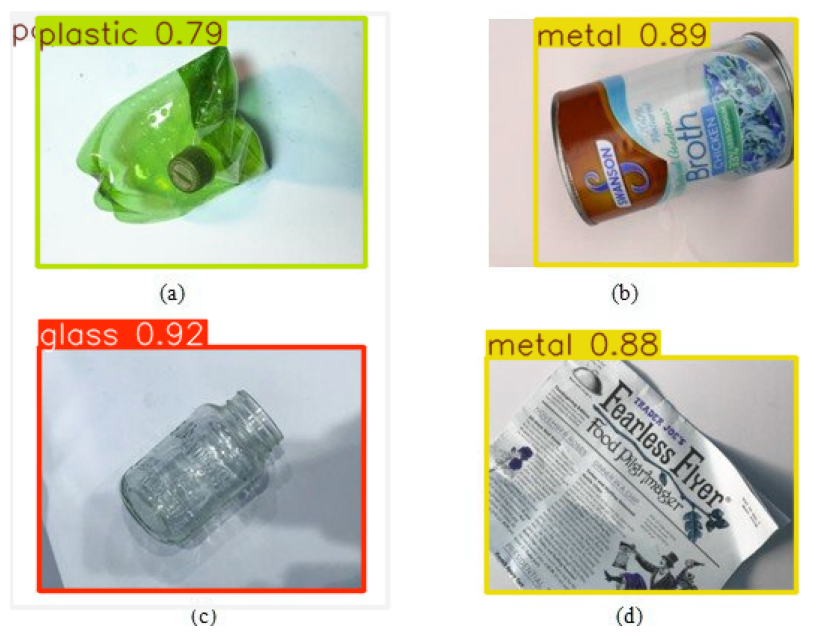

In [3]:
# IMAGE_PATH = 'data_test_real/a.png'
IMAGE_PATH = 'image_3.png'
res = model(IMAGE_PATH, conf=0.2, iou=0.4)
# results = model.predict(source=IMAGE_PATH, conf=0.25, save=True, save_txt=True)
for r in res:
    boxes = r.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = box.conf[0]
            class_name = model.names[class_id]
            
            print(f"Detection {i+1}:")
            print(f"  Class: {class_name}")
            print(f"  Confidence: {confidence:.3f}")
            print(f"  Box: {box.xyxy}")
            print()
            
annotated_image = res[0].plot()
plt.figure(figsize=(12, 8))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

Test on single object image


image 1/1 E:\Workspace\Code\Python\CV_project\data_test_real\a.png: 512x640 1 plastic, 57.5ms
Speed: 4.6ms preprocess, 57.5ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)


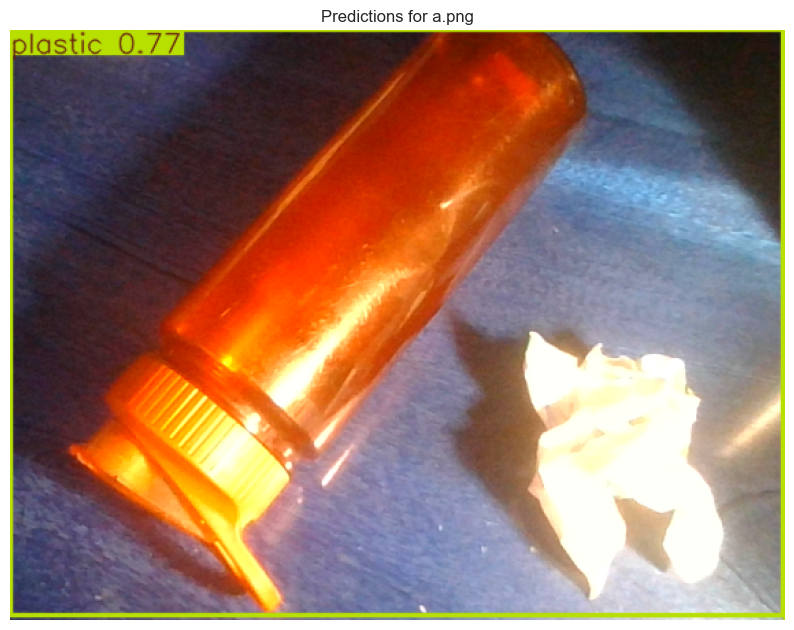

Class: plastic, Confidence: 0.770

image 1/1 E:\Workspace\Code\Python\CV_project\data_test_real\real.jpg: 640x480 1 paper, 59.2ms
Speed: 4.7ms preprocess, 59.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


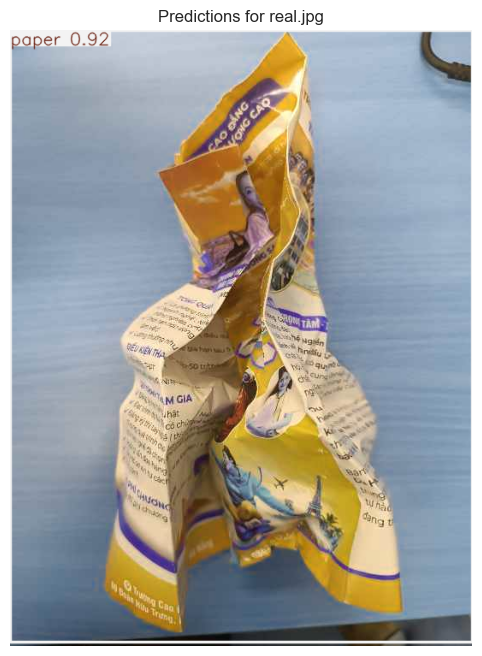

Class: paper, Confidence: 0.917

image 1/1 E:\Workspace\Code\Python\CV_project\data_test_real\can1.jpg: 480x640 1 plastic, 59.4ms
Speed: 4.1ms preprocess, 59.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


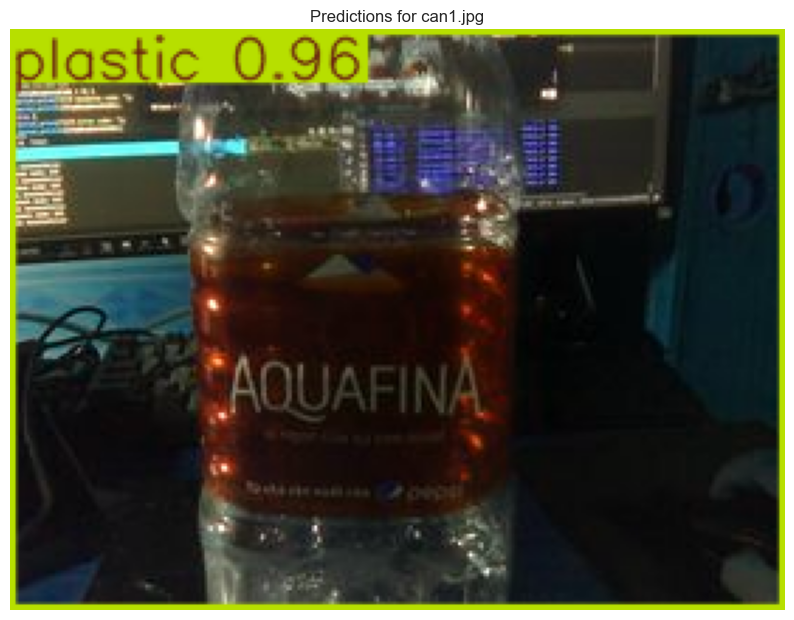

Class: plastic, Confidence: 0.965


In [4]:
def test_single_image(image_path, model):
    # Predict
    results = model(image_path, conf=0.7, iou=0.6)
    
    # Hiển thị kết quả
    result = results[0]
    
    # Vẽ ảnh với bounding boxes
    plotted = result.plot()
    
    # Hiển thị
    plt.figure(figsize=(10, 8))
    plt.imshow(plotted)
    plt.axis('off')
    plt.title(f"Predictions for {os.path.basename(image_path)}")
    plt.show()
    
    # In thông tin chi tiết
    if result.boxes is not None:
        for box in result.boxes:
            cls = int(box.cls)
            conf = float(box.conf)
            class_name = model.names[cls]
            print(f"Class: {class_name}, Confidence: {conf:.3f}")
    else:
        print("No detections")

# Sử dụng
# test_folder = 'data_v3/test/images'
test_folder = 'data_test_real'
n_images = 3

all_test_images = os.listdir(test_folder)
random_test_images = random.sample(all_test_images, min(n_images, len(all_test_images)))
for img_name in random_test_images:
    img_path = os.path.join(test_folder, img_name)
    test_single_image(img_path, model)

Test with folder test images

In [11]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np
from ultralytics import YOLO

In [4]:
# Chạy validation chính thức với YOLO
model = YOLO(r'../results/runs/detect/garbage_detect/weights/best.pt')

# Validation tự động tính mAP, precision, recall
metrics = model.val(data='data_v3/data.yaml', split='test', batch=8)

print(f"mAP@0.5: {metrics.box.map50}")
print(f"mAP@0.5:0.95: {metrics.box.map}")
print(f"Precision: {metrics.box.mp}")
print(f"Recall: {metrics.box.mr}")

Ultralytics 8.3.184  Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 8.95.8 MB/s, size: 63.3 KB)


val: Scanning E:\Workspace\Code\Python\CV_project\data_v3\test\labels.cache... 796 images, 1 backgrounds, 0 corrupt: 100%|██████████| 796/796 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


                   all        796       1060      0.968      0.925      0.961      0.917
                 glass        266        290      0.955      0.873      0.941      0.868
                 metal        229        242      0.957      0.942       0.96      0.936
                 paper        250        260      0.978      0.965      0.985       0.95
               plastic        246        268      0.982      0.922      0.959      0.914
Speed: 0.5ms preprocess, 7.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\val4
mAP@0.5: 0.9610691766674564
mAP@0.5:0.95: 0.9170916608137034
Precision: 0.9678386409116622
Recall: 0.9254346945498356
